In [1]:
# Option for Jupyter Notebook
options(repr.plot.width=12, repr.plot.height=6, repr.plot.res = 180) # option for size of picture output  

# Patchy Dispersal

See nathan et al. 2012 in the folder "03_references".

## Load libraries and script files

In [2]:
library("sf")
library("ggplot2")
library("leaflet")
library("fftwtools")

Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE



In [3]:
# upload files within the 03_src folder
script_files <- list.files("03_src")
for (scr_f in script_files) {
  source(paste0("03_src/", scr_f))
}

Le chargement a nécessité le package : sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.


Attachement du package : ‘fasterize’


L'objet suivant est masqué depuis ‘package:graphics’:

    plot


L'objet suivant est masqué depuis ‘package:base’:

    plot




## Step 1 - Define/Create Landscape

We define a landscape with fields. It's kml file store in `03_data`

see online: https://umap.openstreetmap.fr/fr/

In [4]:
# Store Data and parameter Input in list
DATA = list()
INPUT = list()

In [5]:
DATA$landscapeSOURCE = sf::st_read("03_data/1_1_landscapeSOURCE.kml")
DATA$landscapeHOST   = sf::st_read("03_data/1_2_landscapeHOST.kml")

Reading layer `1_landscapeSOURCE' from data source 
  `/home/virgile/Documents/qonfluens/formation/2023_spatial_analysis_modelling/01_Compartimental_Models/03_data/1_1_landscapeSOURCE.kml' 
  using driver `LIBKML'
Simple feature collection with 21 features and 67 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 3.014885 ymin: 42.04307 xmax: 3.029733 ymax: 42.05748
Geodetic CRS:  WGS 84
Reading layer `2_landscapeHOST' from data source 
  `/home/virgile/Documents/qonfluens/formation/2023_spatial_analysis_modelling/01_Compartimental_Models/03_data/1_2_landscapeHOST.kml' 
  using driver `LIBKML'
Simple feature collection with 1 feature and 12 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 3.015978 ymin: 42.04278 xmax: 3.034837 ymax: 42.05684
Geodetic CRS:  WGS 84


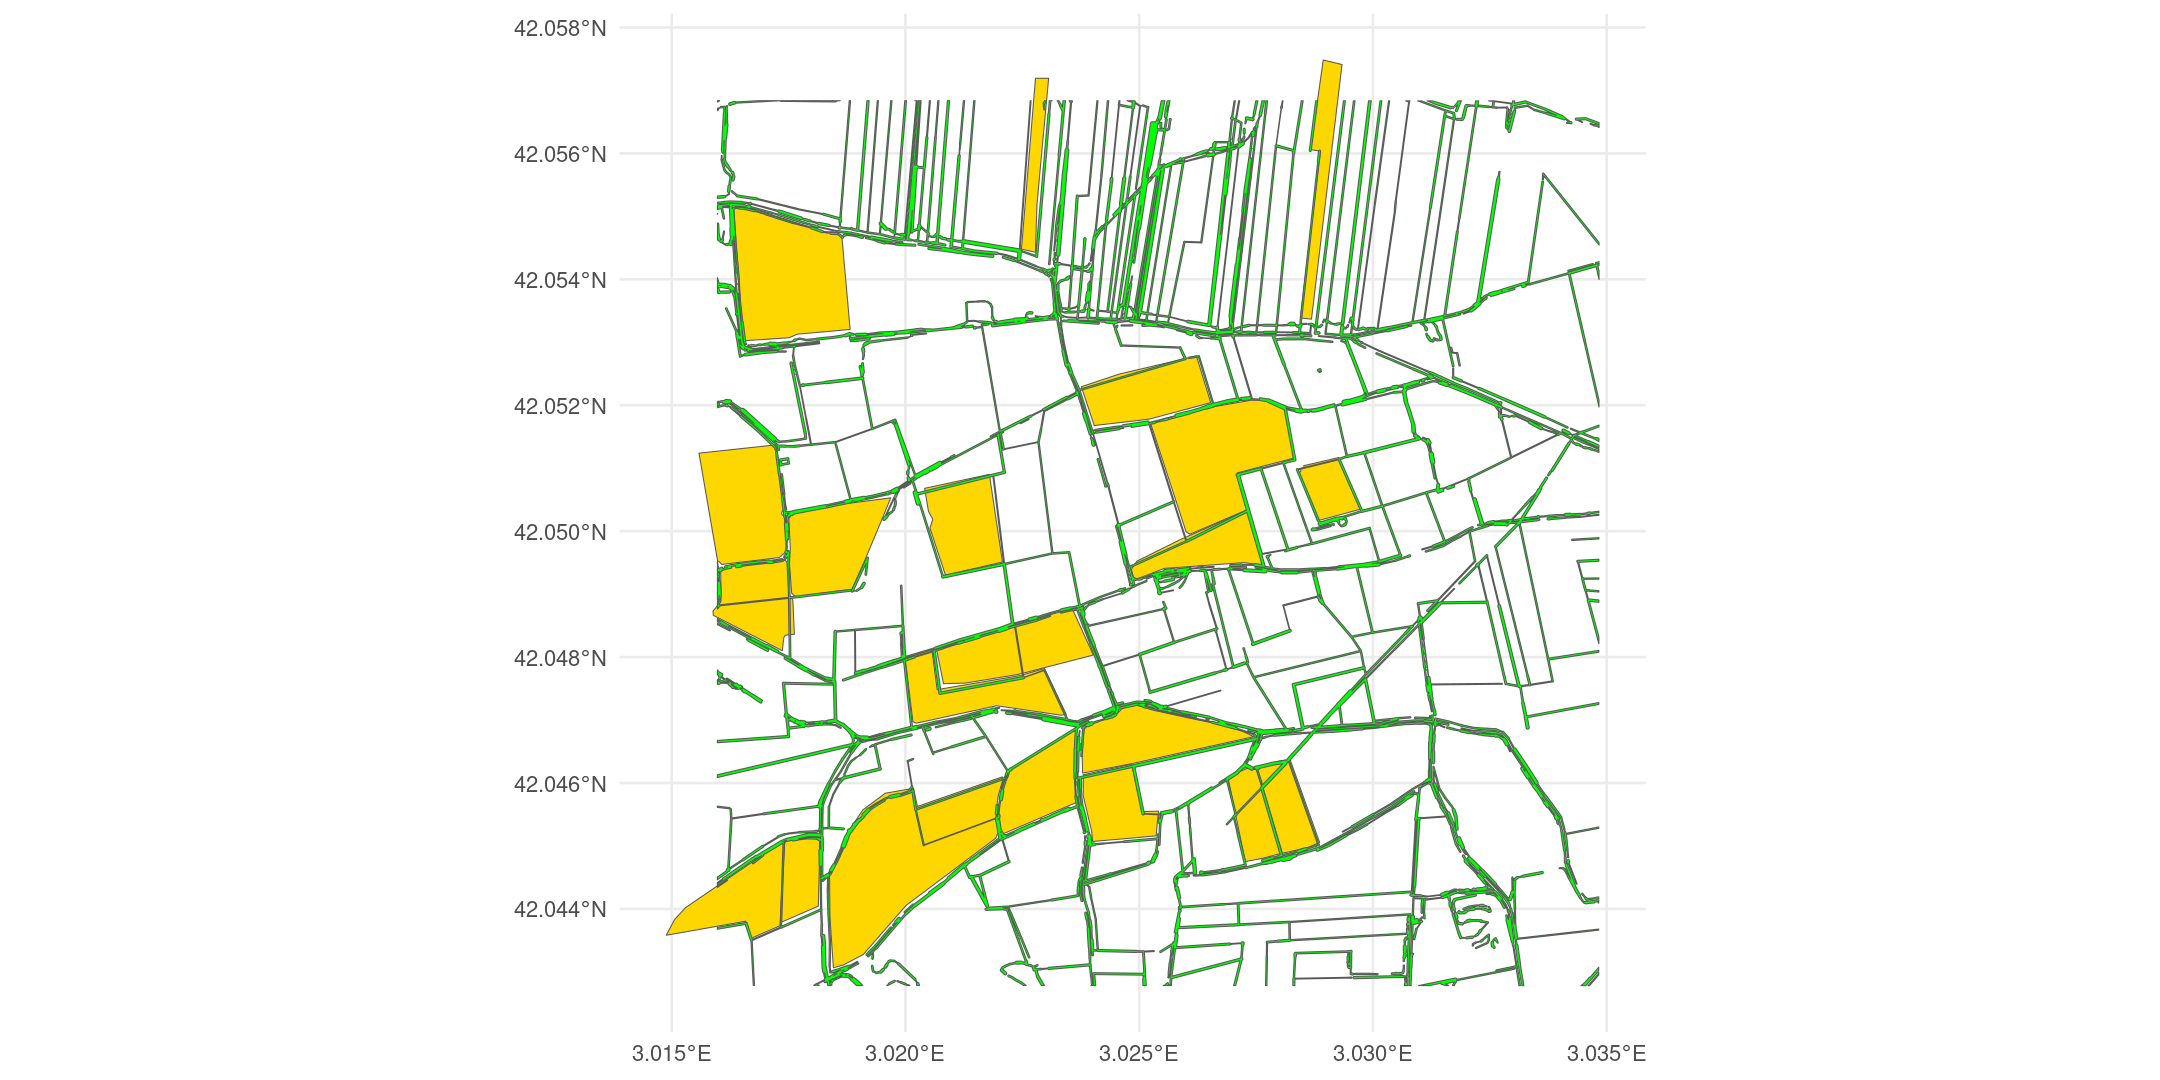

In [6]:
plt <- ggplot() + theme_minimal() +
  scale_fill_manual(values = c("grey", "orange"),
                    name = "Maize") +
  geom_sf(data = DATA$landscapeSOURCE, fill = "gold") +
  geom_sf(data = DATA$landscapeHOST, fill = "green")
plt

## Step 2 - Dispersal of Propagule

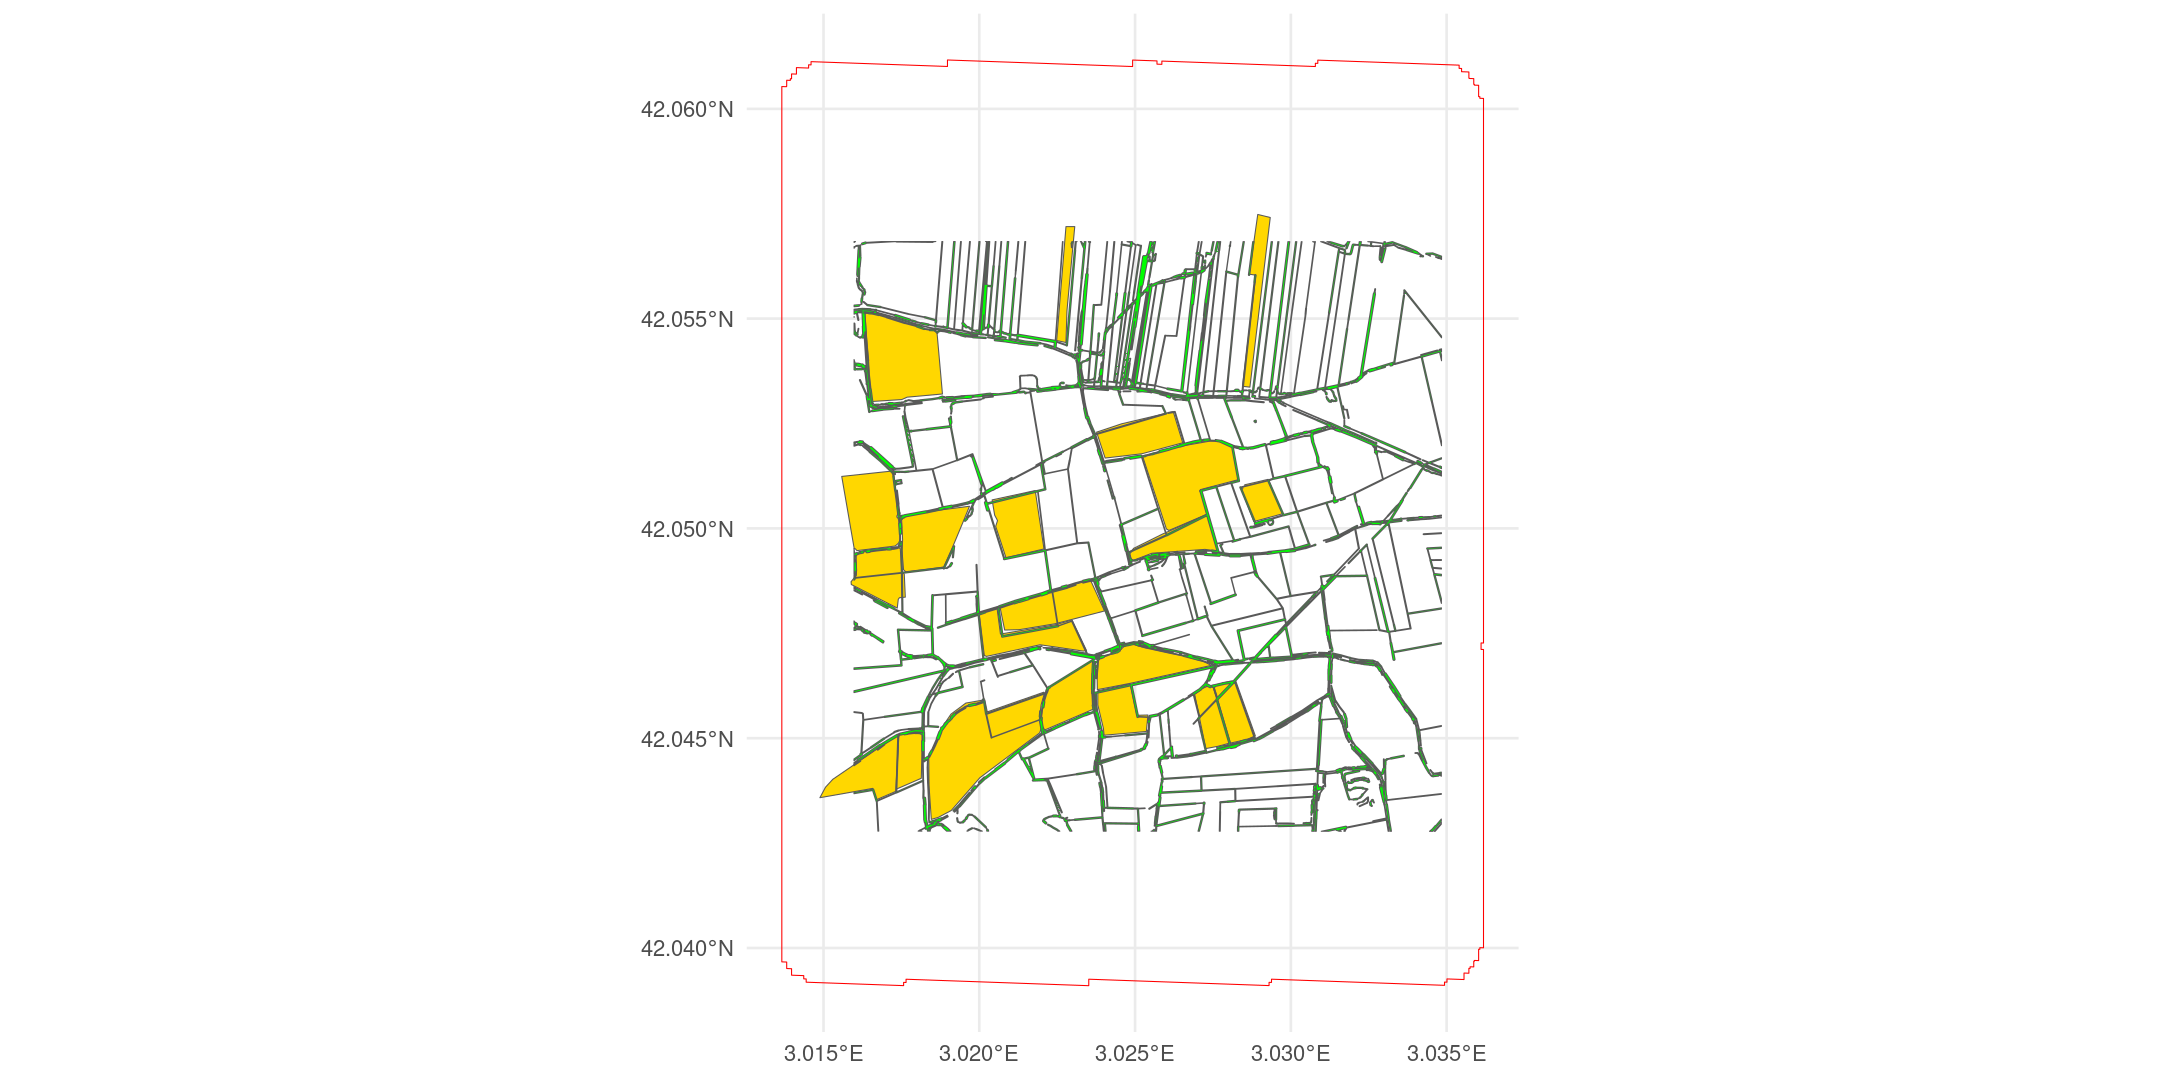

In [7]:
# 1. Define a squareFrame
INPUT$squareFrameBuffer = 100

DATA$landscapeSQUAREFRAME <- st_squared_geometry(
    list(DATA$landscapeSOURCE, DATA$landscapeHOST),
    buffer = INPUT$squareFrameBuffer
    )
plt + geom_sf(data = DATA$landscapeSQUAREFRAME, color = "red", fill = NA)

In [8]:
# 2. Dispersal
INPUT$kernelSizeRaster = 256
INPUT$kernelParam = -100
DATA$stack_dispersal <- brk_dispersal(DATA$landscapeSOURCE,
                                size_raster = INPUT$kernelSizeRaster,
                                tolerance_square = 0.1,
                                kernel = "geometric",
                                kernel.options =  list("a" =  INPUT$kernelParam),
                                squared_frame = DATA$landscapeSQUAREFRAME)

Starting dispersal computing...

Raster size : 2.56e+02

Step 1/2: Rasterize... 
done

Step 2/2: Compute field... 
1... 
2... 
3... 
4... 
5... 
6... 
7... 
8... 
9... 
10... 
11... 
12... 
13... 
14... 
15... 
16... 
17... 
18... 
19... 
20... 
21... 
done



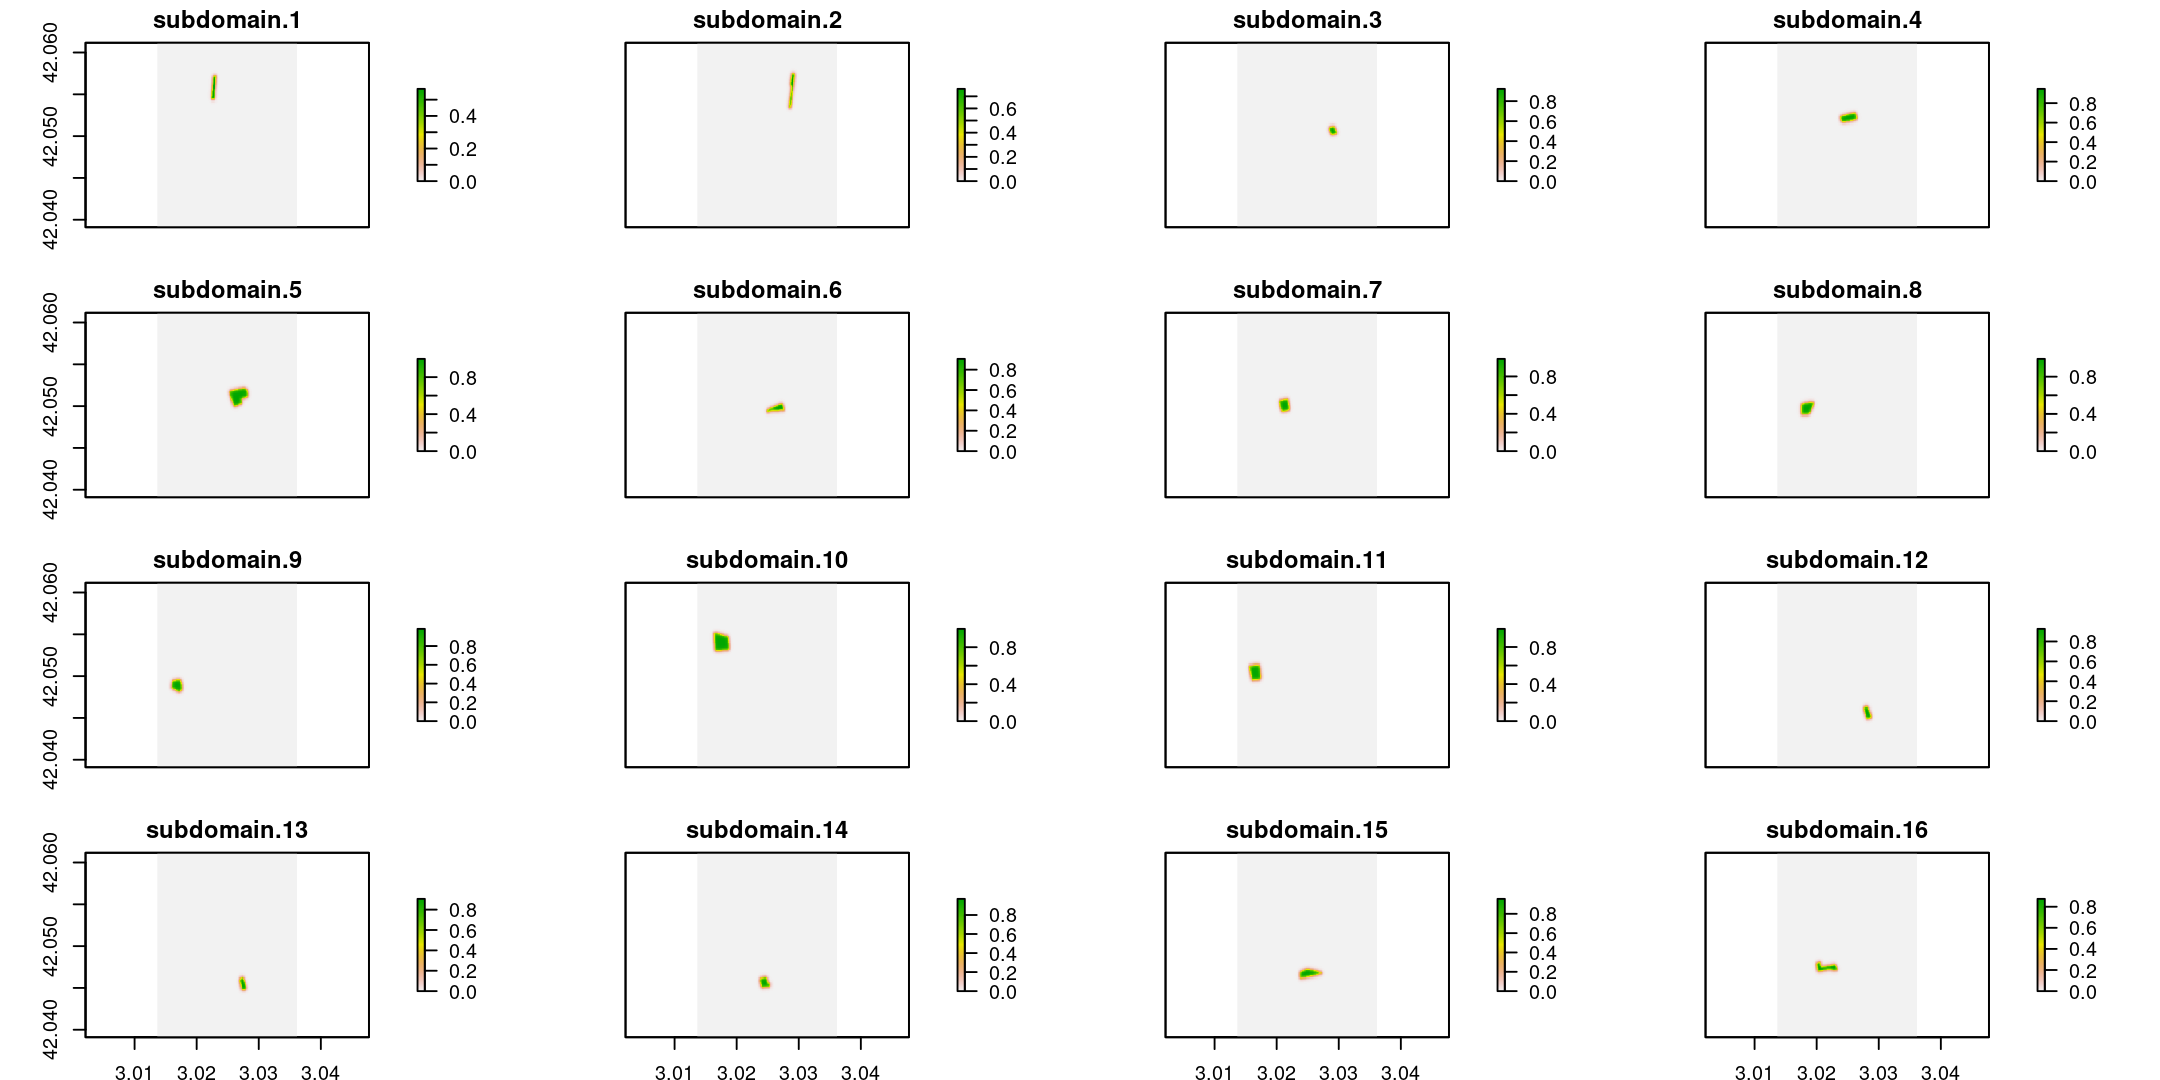

In [9]:
plot(DATA$stack_dispersal)

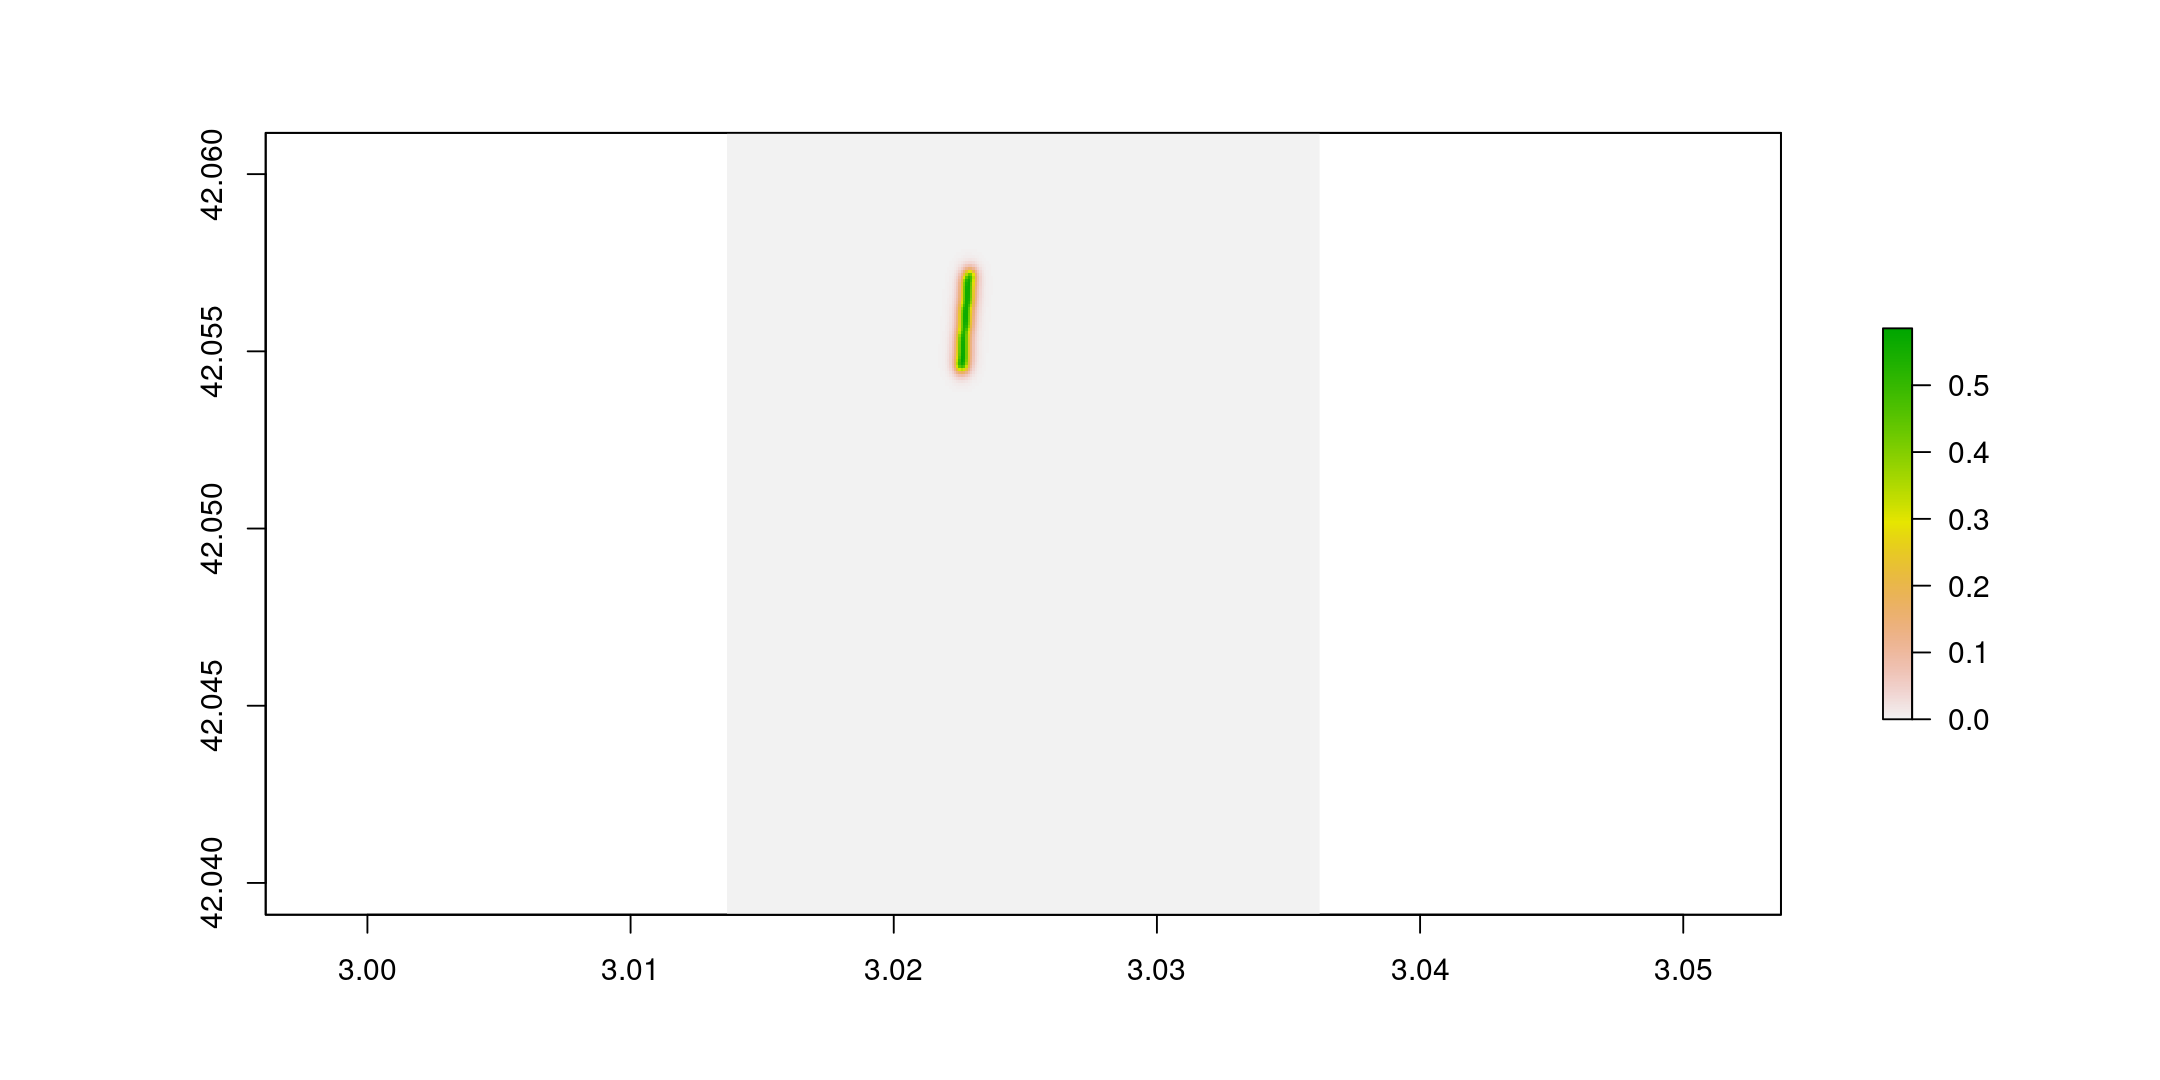

In [10]:
plot(DATA$stack_dispersal[[1]])

## Step 3 - Set Emission Profiles

In [11]:
INPUT$periodEMISSION = c(
        as.Date("01-07-2020", format = "%d-%m-%Y"),
        as.Date("01-09-2020", format = "%d-%m-%Y")
    )
INPUT$betaSPREAD = 0.2
INPUT$lossSPREAD = 0.1
INPUT$pollenSCALE = 1.6
INPUT$pollenSHAPE = 10

In [12]:
proportionPOLLEN = c(
    0.0165, 0.0660, 0.1545, 0.1885, 0.1735,
    0.1560, 0.1159, 0.0670, 0.0377, 0.0167, 0.0055, 0.0022)

funTimePollen <- function(time, pollenShape, pollenScale){
    density = runif(1, 7, 11) # nbr plants / pixel
    pollen = rgamma(1, shape = pollenShape, scale = pollenScale) #nbr pollen/plant
    nbr_days = length(time)
    deb = sample(1:(nbr_days - length(proportionPOLLEN)), 1)
    end = (deb + length(proportionPOLLEN) - 1)
    pollen_emission <- rep(0, nbr_days)
    pollen_emission[deb:end] <- as.numeric(pollen * density * proportionPOLLEN)
    return(pollen_emission)
}

message("Compute emission timeline")
sourceEMISSIONlist = dplyr::tibble(
    Date = lapply(1:nrow(DATA$landscapeSOURCE), function(i){ seq(min(INPUT$periodEMISSION), max(INPUT$periodEMISSION), by = "day")})
)
sourceEMISSIONlist$IDsource = 1:nrow(sourceEMISSIONlist)

message("Compute emission profile")
sourceEMISSIONlist$EMISSION = lapply(1:nrow(sourceEMISSIONlist), function(i){
    funTimePollen(sourceEMISSIONlist$Date[[i]],
                pollenShape = INPUT$pollenSHAPE, pollenScale = INPUT$pollenSCALE
                )
})

message("Reframe Emission object")
DATA$sourceEMISSION = sourceEMISSIONlist %>%
    tidyr::unnest(cols = c("Date", "EMISSION"))

Compute emission timeline

Compute emission profile

Reframe Emission object



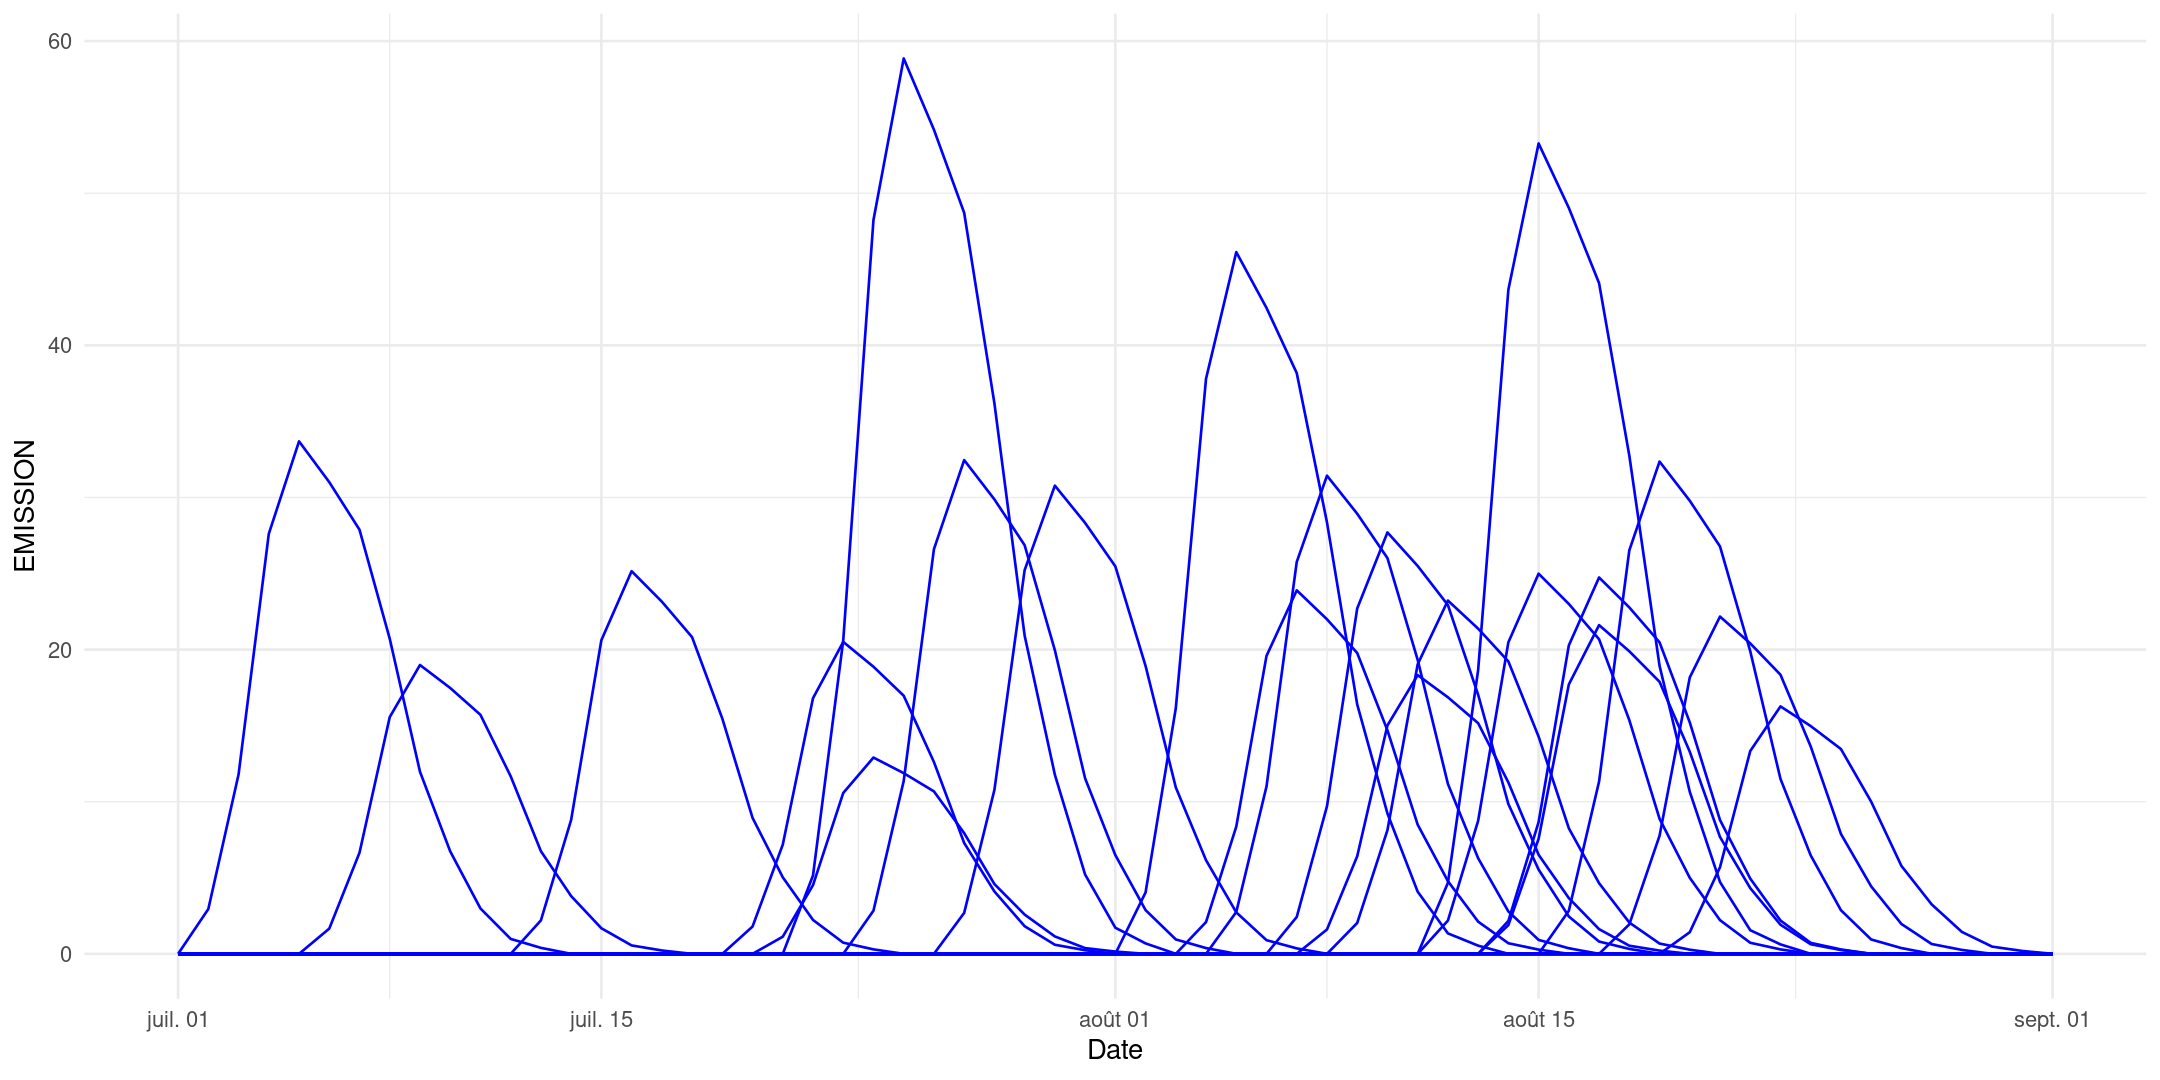

In [13]:
DATA$sourceEMISSION %>%
    ggplot() + 
    theme_minimal() +
    geom_line(aes(x=Date, y=EMISSION, group=IDsource), color = "blue")

In [14]:
# Number of pollen emitted per pixel per patches per day
message("Reframe for emission stack")
sourceEMISSION_stack = DATA$sourceEMISSION %>%
    dplyr::group_by(IDsource) %>%
    dplyr::arrange(Date) %>%
    dplyr::summarize(Date = list(Date),
                    EMISSION = list(EMISSION))

Reframe for emission stack



In [15]:
message("Compute exposure raster stack")
DATA$stack_exposure <- brk_exposure( DATA$stack_dispersal,
                                        sourceEMISSION_stack,
                                        key = "EMISSION", # Name of the new column
                                        keyTime = "Date", # Length of the reference timeline
                                        loss = INPUT$lossSPREAD,
                                        beta = INPUT$betaSPREAD,
                                        quiet = FALSE,
                                        unit = "any")

Compute exposure raster stack

Step 1/2: Compute global spatio-temporal exposure profile... 



 | * * * * * * * * * * 

done 

Step 2/2: Convert all matrices to rasters... 
done 



In [16]:
cell_area <- raster::area(DATA$stack_exposure)[1] * 10^5 #to convert km2 to m2
stack_exposure_m2 <- DATA$stack_exposure / cell_area

Warning message in .couldBeLonLat(x, warnings = warnings):
“CRS is NA. Assuming it is longitude/latitude”


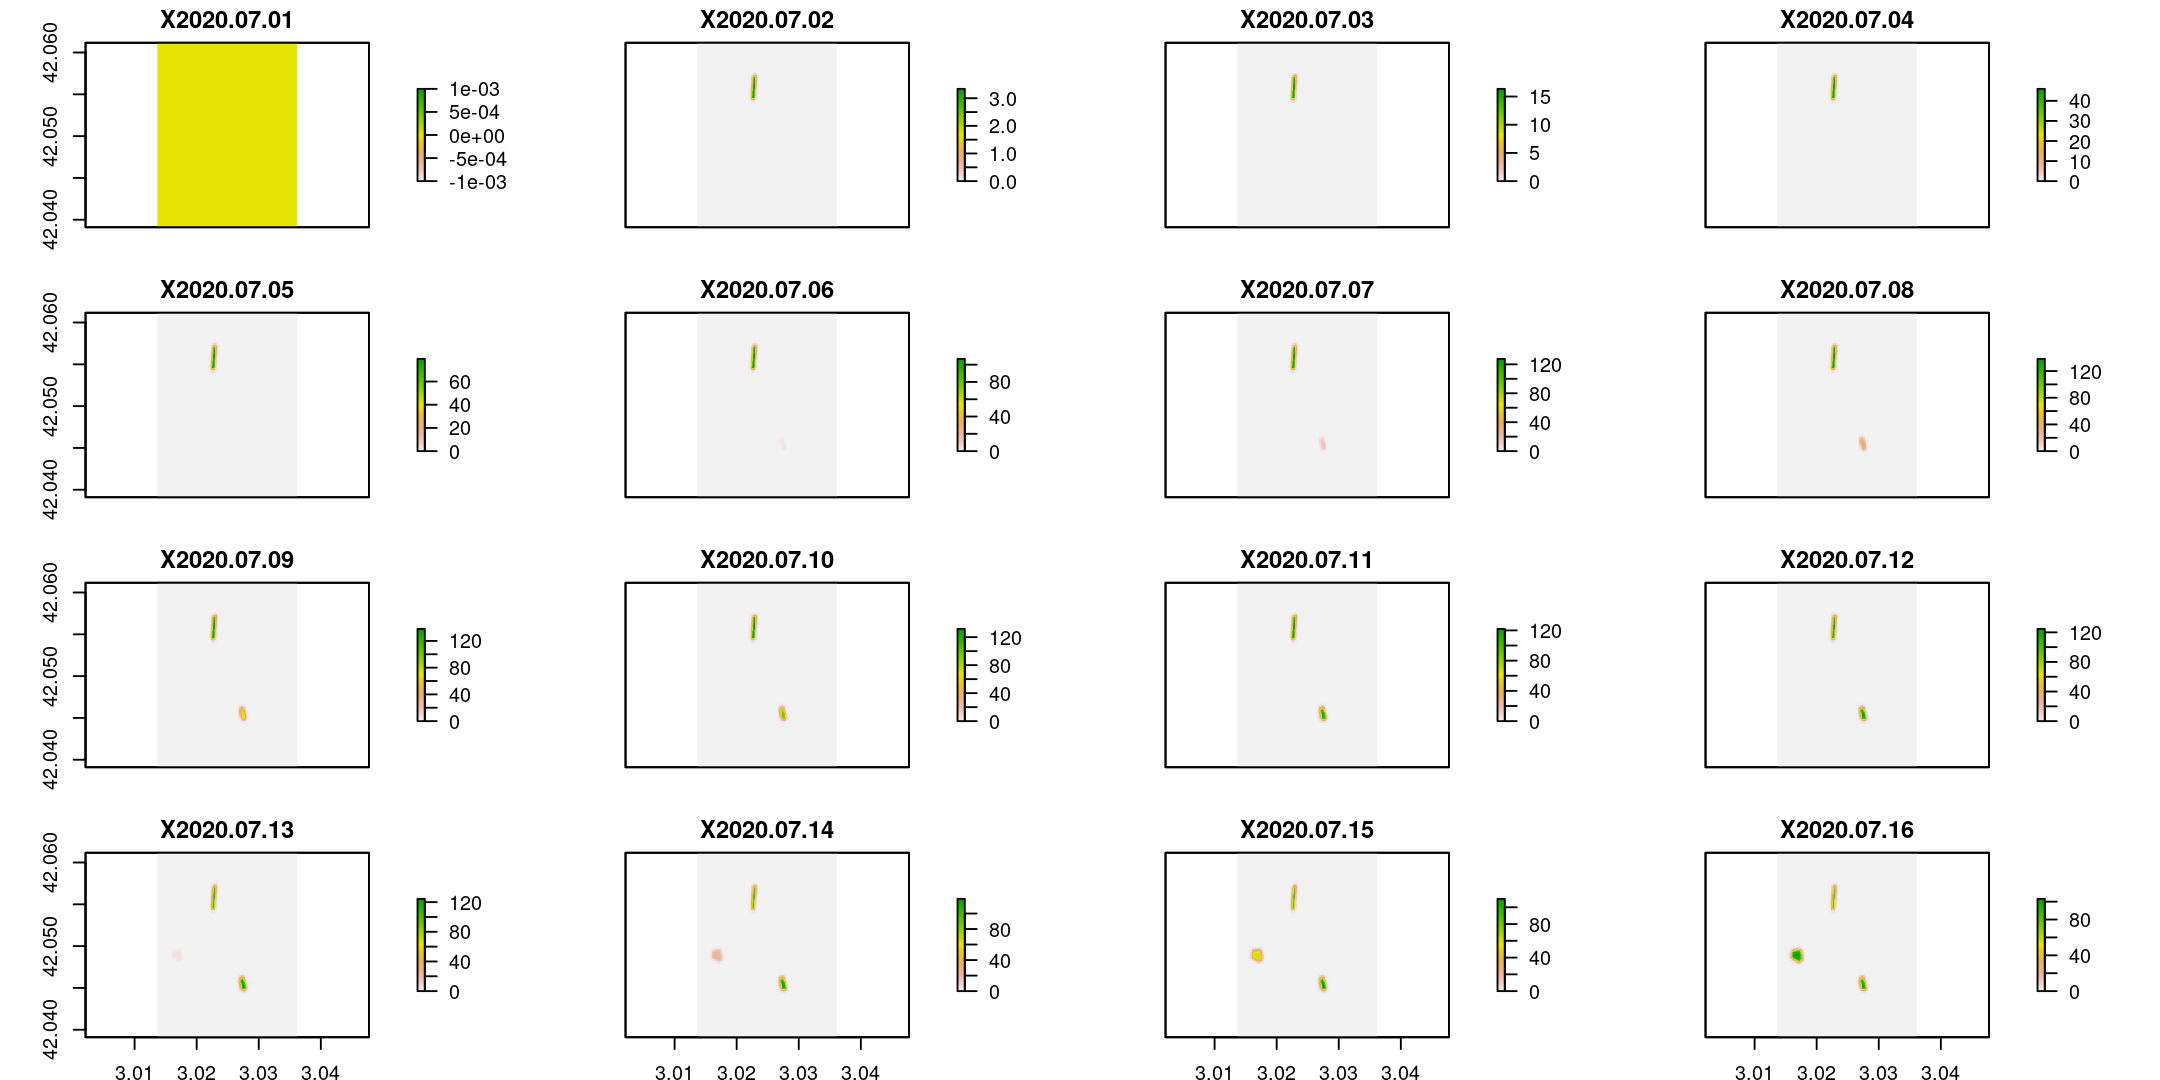

In [17]:
plot(stack_exposure_m2)

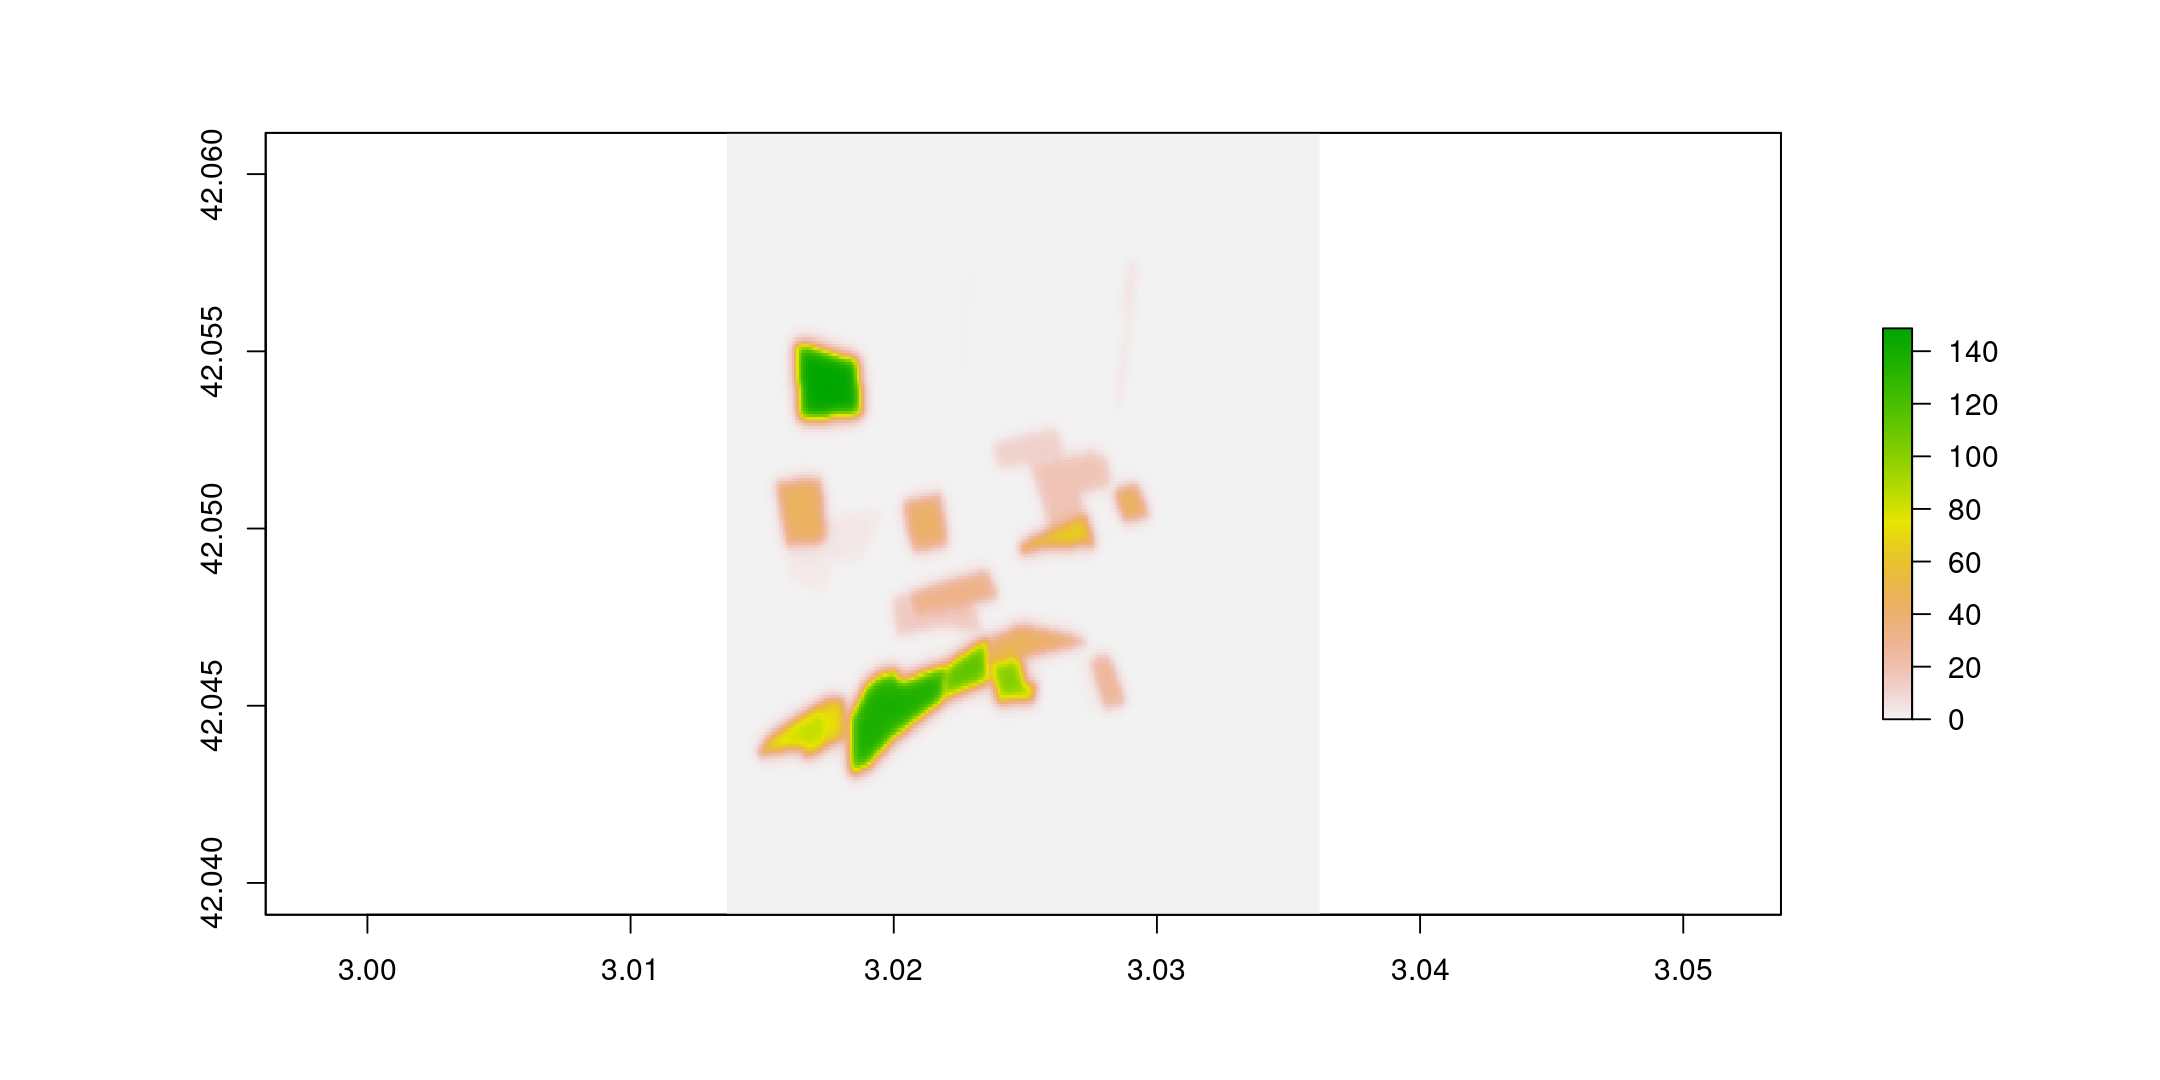

In [18]:
plot(stack_exposure_m2[[60]])

## Step 4 - Plot on leaflet

In [19]:
landscapeSQUAREFRAME_WGS84 = sf::st_transform(DATA$landscapeSQUAREFRAME, crs = 4326)
landscapeSOURCE_WGS84 = sf::st_transform(DATA$landscapeSOURCE, crs = 4326)
landscapeHOST_WGS84 = sf::st_transform(DATA$landscapeHOST, crs = 4326)

In [20]:
rast = stack_exposure_m2[[60]]
crs(rast) = CRS("+init=epsg:4326")
rast[rast <= 10^-3] <- NA
pal = colorNumeric(c("#0C2C84", "#41B6C4", "#FFFFCC"), values(rast), na.color = "transparent")
vmn = min(values(rast), na.rm = TRUE)
vmx = max(values(rast), na.rm = TRUE)

Warning message in CPL_crs_from_input(x):
“GDAL Message 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.”


In [21]:
mapRISK = leaflet() %>%
        addTiles() %>%
      # fitBounds(frameBox[1]*(1-zoom),frameBox[2]*(1-zoom),frameBox[3]*(1+zoom), frameBox[4]*(1+zoom)) %>% # ~min(Long), ~min(Lat), ~max(Long), ~max(Lat) 
      addPolygons(data = landscapeSQUAREFRAME_WGS84,
                  weight = 2,
                  color = "grey",
                  fill = FALSE,
                  # fillOpacity = 0.5,
                  group = "Frame") %>%
      addPolygons(data = landscapeSOURCE_WGS84,
                  weight = 2,
                  color = "gold",
                  fillOpacity = 0.7,
                  group = "Source") %>%
      addPolygons(data = landscapeHOST_WGS84,
                  weight = 2,
                  color = "green",
                  fillOpacity = 0.7,
                  group = "Host") %>%
      # Layers control
      addLayersControl(
        overlayGroups = c("Frame", "Source", "Host"),
        options = layersControlOptions(collapsed = FALSE)
      ) %>%
      addRasterImage(rast, color = pal, opacity = 0.5) %>%
      addLegend(pal = pal, values = c(vmn, vmx), title = "level dispersal")

HTML widgets cannot be represented in plain text (need html)
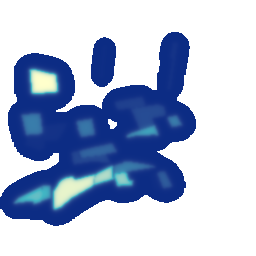

In [22]:
mapRISK